# NLP notebook

In [24]:
!py -m pip install wordcloud

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ----- ---------------------------------- 41.0/300.2 kB 1.9 MB/s eta 0:00:01
   ----------------------- ---------------- 174.1/300.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 3.1 MB/s eta 0:00:00


In [26]:
import pandas as pd
import json
import os
from tqdm import tqdm
import numpy as np
import gzip
import shutil
import xml.etree.ElementTree as ET
import stanza
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import string
import spacy
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.io as pio
import itertools
import json
from wordcloud import WordCloud
from PIL import Image
from collections import Counter

Color palette:

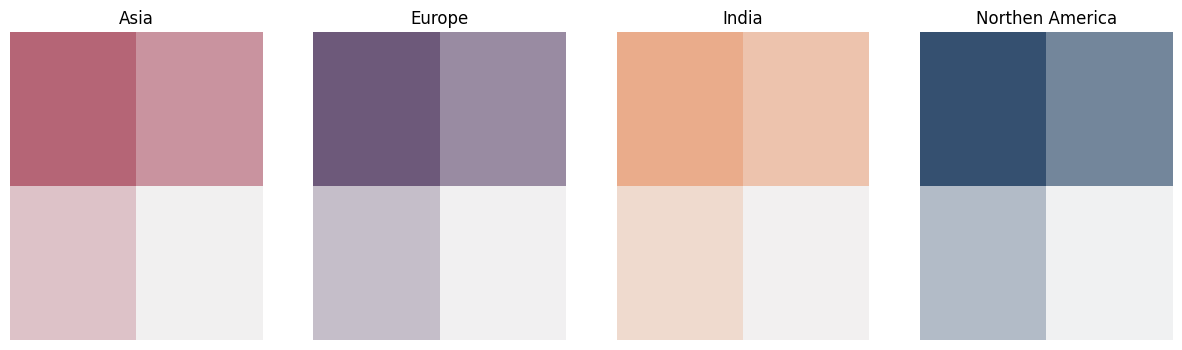

In [2]:
areas = ["Asia", "Europe", "India", "Northen America"]
area_color = {
  "Asia": "#b56576",
  "Europe": "#6d597a",
  "India": "#eaac8b",
  "Northen America": "#355070"
}
world_color = "#a04144"

area_palette = {area: sns.light_palette(area_color[area], reverse=True, as_cmap=True) for area in areas}

area_palette_4 = {area: sns.light_palette(area_color[area], reverse=True, n_colors=4) for area in areas}

# Display the palette 4 in a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
for i, area in enumerate(areas):
  sns.heatmap(np.arange(4).reshape(2, 2), cmap=area_palette_4[area], cbar=False, ax=axes[i])
  axes[i].set_title(area)
  axes[i].axis("off")
plt.show()


### 1.3. Plot summaries extraction and cleaning

The corenlp_plot_summaries dataset is composed of gzipped folders, each containing a single xml file with matching name. Each folder-file corresponds to one movie, and the name is the movie ID.

We thus need to extract all zipped folder, and get the XML file. To do this, we will follow these steps:

1. Extract the gzipped folder using gzip package.
2. Move extracted files to a unique folder in clean_data.
3. Remove the empty folders after moving the files.

Same as above, this step only need to be performed one time.


In [ ]:
# Path to the zipped folders
NLP_DATA_PATH = "../corenlp_plot_summaries/"

# Path to the new data folder
NLP_SUMMARIES = "clean_data/NLP_summaries/"

# Create the new data folder if it doesn't exist
if not os.path.exists(NLP_SUMMARIES):
    os.makedirs(NLP_SUMMARIES)

# Iterate through each gzipped folder
for root, dirs, files in os.walk(NLP_DATA_PATH):
    for file in files:
        # Check if the file is a gzipped file
        if file.endswith(".gz"):
            # Path to the gzipped file contained in the folder
            gz_path = os.path.join(root, file)

            # Create a folder name based on the gzipped file name, removing the extension
            folder_name = os.path.splitext(file)[0]

            # Path to the destination folder
            destination_folder = os.path.join(NLP_SUMMARIES, folder_name)

            # Unzip the contents of the gzipped file to the destination folder
            with gzip.open(gz_path, "rb") as gz_file:
                with open(destination_folder, "wb") as out_file:
                    shutil.copyfileobj(gz_file, out_file)

# Move all XML files from the unzipped folders to the clean data folder
for root, dirs, files in os.walk(NLP_SUMMARIES):
    for file in files:
        # Check if the file is an XML file
        if file.endswith(".xml"):
            # Path to the XML file
            xml_path = os.path.join(root, file)

            # Move the XML file
            shutil.move(xml_path, os.path.join(NLP_SUMMARIES, file))

# Remove the empty folders left after moving the XML files
for root, dirs, files in os.walk(NLP_SUMMARIES, topdown=False):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        os.rmdir(folder_path)

Now, each XML file is stored in clean_data folder and can be read to analyze summary informations.


### 2.5 Exploration of plot summaries


In this part, we will first analyze the results of the CoreNLP pipeline already run on the summaries, stored in `clean_data/NLP_summaries`, and then apply sentiment analysis on the raw summaries. Afterwards, we will put all together to build an analysis pipeline relative to our project.

Let's first prepare the necessary variables:

In [9]:
# Path to the new data folder
NLP_SUMMARIES = "clean_data/NLP_summaries/"

# Define data path
CLEAN_DATA_PATH = "clean_data/"

In [7]:
# Read the 2 csv from summary and movies to link summaries to wiki_id
summaries_df = pd.read_csv("clean_data/movies_summaries.csv")
movies_df = pd.read_csv("clean_data/movies.csv")

# Add wiki_id from movies_df to summaries_df
summaries_df = summaries_df.rename(columns={"movie_id": "id"})
summaries_df = summaries_df.merge(movies_df[["id", "wiki_id"]], on="id")
display(summaries_df.head())

,id,summary,wiki_id
0,/m/076w2lb,"Shlykov, a hard-working taxi driver and Lyosha...",23890098
1,/m/0gkz15s,The nation of Panem consists of a wealthy Capi...,31186339
2,/m/051zjwb,Poovalli Induchoodan is sentenced for six yea...,20663735
3,/m/06xtz3,"The Lemon Drop Kid , a New York City swindler,...",2231378
4,/m/02tqm5,Seventh-day Adventist Church pastor Michael Ch...,595909



**CoreNLP results for one summary**

To begin, we will select one movie by specifying its ID and look at the data from the corresponding XML file.

To have the files, it is necessary to:

- download the supplementary dataset and put it at the level of the cloned repository
- run the section 1.3 to extract all files


In [4]:
# Select a movie
wiki_id = 23890098

# Path to the XML file
summary_test_file = NLP_SUMMARIES + str(wiki_id) + ".xml"
print(summary_test_file)

clean_data/NLP_summaries/23890098.xml


In [8]:
# Access the summary where wiki_id = movie_id
summary_test = summaries_df.loc[summaries_df['wiki_id'] == wiki_id]['summary'].values[0]
print(summary_test)

Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.


Each `<token>` element represents a word from a sentence, identified by a unique `id`. Inside each `<token>` element, there are several child elements that provide more information about the token:

- `<word>`: The actual word in the text.
- `<lemma>`: The base or dictionary form of the word.
- `<CharacterOffsetBegin>` and `<CharacterOffsetEnd>`: The start and end positions of the word in the original text.
- `<POS>`: The part-of-speech tag for the word. POS tagging is the task of labeling the words in a sentence with their appropriate part of speech (noun, verb, adjective, etc.).
- `<NER>`: Named Entity Recognition tag. NER is a subtask of information extraction that seeks to locate and classify named entities in text into predefined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

The `<sentence>` element contains a set of these tokens, representing a sentence in the text. The `id` attribute of the `<sentence>` element indicates the order of the sentence in the document.


In [4]:
# Parse the XML file and get the root element
tree = ET.parse(summary_test_file)
root = tree.getroot()

# Create an empty dict to store data
tokens_dict = {}

# Iterate over all 'token' elements in the document
for i,sentence in enumerate(root.iter("sentence")):
    tokens_dict[i+1] = {}
    for token in sentence.iter("token"):
        # Extract data from the child elements of 'token'
        word = token.find("word").text
        lemma = token.find("lemma").text
        pos = token.find("POS").text
        ner = token.find("NER").text

        # Store in dict
        token_id = token.attrib["id"]
        tokens_dict[i+1][token_id] = {
            "word": word,
            "lemma": lemma,
            "POS": pos,
            "NER": ner,
        }

# Print the dict
print(tokens_dict)

{'1': {'word': 'Shlykov', 'lemma': 'Shlykov', 'POS': 'NNP', 'NER': 'PERSON'}, '2': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '3': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '4': {'word': 'hard-working', 'lemma': 'hard-working', 'POS': 'JJ', 'NER': 'O'}, '5': {'word': 'taxi', 'lemma': 'taxi', 'POS': 'NN', 'NER': 'O'}, '6': {'word': 'driver', 'lemma': 'driver', 'POS': 'NN', 'NER': 'O'}, '7': {'word': 'and', 'lemma': 'and', 'POS': 'CC', 'NER': 'O'}, '8': {'word': 'Lyosha', 'lemma': 'Lyosha', 'POS': 'NNP', 'NER': 'PERSON'}, '9': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '10': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '11': {'word': 'saxophonist', 'lemma': 'saxophonist', 'POS': 'NN', 'NER': 'O'}, '12': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '13': {'word': 'develop', 'lemma': 'develop', 'POS': 'VB', 'NER': 'O'}, '14': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '15': {'word': 'bizarre', 'lemma': 'bizarre', 'POS': 'JJ', 'NER

Each sentence also has dependency informations between tokens:

- `<basic-dependencies>`: These represent grammatical relationships between words in a sentence. For example, the dependencies between noun and verb.

- `<collapsed-dependencies>`: These are a simplified form of dependencies where certain types of indirect dependencies are collapsed into direct dependencies for easier processing.


In [ ]:
# Create an empty dict to store data
dep_dict = {}

# Extract and print dependencies
for i, dep in enumerate(root.iter("dep")):
    # Extract data
    dep_type = dep.attrib["type"]
    governor = dep.find("governor").text
    dependent = dep.find("dependent").text

    # Store in dict
    dep_dict[i] = {"type": dep_type, "governor": governor, "dependent": dependent}


print(dep_dict)

{0: {'type': 'prep', 'governor': 'is', 'dependent': 'After'}, 1: {'type': 'auxpass', 'governor': 'pulled', 'dependent': 'being'}, 2: {'type': 'pcomp', 'governor': 'After', 'dependent': 'pulled'}, 3: {'type': 'prep', 'governor': 'pulled', 'dependent': 'through'}, 4: {'type': 'det', 'governor': 'portal', 'dependent': 'a'}, 5: {'type': 'nn', 'governor': 'portal', 'dependent': 'time'}, 6: {'type': 'pobj', 'governor': 'through', 'dependent': 'portal'}, 7: {'type': 'nn', 'governor': 'lands', 'dependent': 'Ash'}, 8: {'type': 'nn', 'governor': 'lands', 'dependent': 'Williams'}, 9: {'type': 'nsubj', 'governor': 'is', 'dependent': 'lands'}, 10: {'type': 'prep', 'governor': 'lands', 'dependent': 'in'}, 11: {'type': 'num', 'governor': 'AD', 'dependent': '1300'}, 12: {'type': 'pobj', 'governor': 'in', 'dependent': 'AD'}, 13: {'type': 'advmod', 'governor': 'captured', 'dependent': 'where'}, 14: {'type': 'nsubjpass', 'governor': 'captured', 'dependent': 'he'}, 15: {'type': 'auxpass', 'governor': 'cap

Finaly, dependencies between different sentences can be analyzed:

- `<coreferences>`: These represent instances where multiple expressions in a text refer to the same entity.

In the XML, each `<coreference>` element represents a group of mentions that all refer to the same entity in the text. Each `<mention>` element within a `<coreference>` represents a specific instance where that entity is mentioned in the text.
The `<mention representative="true">` is the primary mention in the text that other mentions refer back to.

The `<sentence>` tag within a `<mention>` indicates the sentence number where the mention occurs. The `<start>` and `<end>` tags indicate the position of the start and end of the mention within that sentence. The `<head>` tag indicates the head word of the mention.

To know what a coreference corresponds to in the actual text, we would need to find the sentences and word positions indicated by the `<sentence>`, `<start>`, and `<end>` tags in the text itself.


In [ ]:
# Create an empty dict to store data
coref_dict = {}

# Extract and print coreferences
for i, coref in enumerate(root.iter("coreference")):
    coref_dict[i] = {}
    for j, mention in enumerate(coref.iter("mention")):
        # Extract data
        sentence = mention.find("sentence").text
        start = mention.find("start").text
        end = mention.find("end").text

        # Store in dict
        coref_dict[i][j] = {"sentence": sentence, "start": start, "end": end}

print(coref_dict)

{0: {0: {'sentence': '1', 'start': '23', 'end': '26'}, 1: {'sentence': '3', 'start': '18', 'end': '20'}, 2: {'sentence': '2', 'start': '6', 'end': '15'}, 3: {'sentence': '1', 'start': '36', 'end': '38'}, 4: {'sentence': '2', 'start': '6', 'end': '9'}, 5: {'sentence': '2', 'start': '8', 'end': '9'}, 6: {'sentence': '4', 'start': '3', 'end': '4'}, 7: {'sentence': '4', 'start': '5', 'end': '6'}, 8: {'sentence': '5', 'start': '1', 'end': '2'}, 9: {'sentence': '21', 'start': '21', 'end': '23'}, 10: {'sentence': '16', 'start': '17', 'end': '19'}, 11: {'sentence': '21', 'start': '34', 'end': '35'}, 12: {'sentence': '15', 'start': '14', 'end': '23'}, 13: {'sentence': '15', 'start': '14', 'end': '16'}, 14: {'sentence': '1', 'start': '13', 'end': '42'}, 15: {'sentence': '1', 'start': '13', 'end': '15'}, 16: {'sentence': '1', 'start': '33', 'end': '42'}, 17: {'sentence': '1', 'start': '17', 'end': '18'}, 18: {'sentence': '1', 'start': '30', 'end': '31'}, 19: {'sentence': '2', 'start': '1', 'end':

We finally get for each summary:

- A `token dictionnary` containing the word, lemma, POS and NER of each tokens (words) of the summary.
- A `dependency dictionnary` containing each gramatical dependencies found in the summary along with the dependency type.
- A `coreference dictionnary` referencing for each coreference (entity refered to) all the group of words related to it in a specific sentence.

To be used for all summaries, we built a function to extract those 3 dictionnaries from the XML file.


In [13]:
def extract_NLP_data(xml_file):
    """
    Extracts the tokens, dependencies and coreferences from an XML file
    and returns them in a dict.

    Args
        xml_file (str): Path to the XML file.

    Returns
        tokens_dict (dict): Dict containing the tokens.
        dep_dict (dict): Dict containing the dependencies.
        coref_dict (dict): Dict containing the coreferences.
    """
    # Parse the XML file and get the root element
    tree = ET.parse(xml_file)
    root = tree.getroot()

    
    # Create an empty dict to store data
    tokens_dict = {}
    dep_dict = {}

    # Iterate over sequences
    for i,sentence in enumerate(root.iter("sentence")):
        #---------- Extract tokens ----------#
        tokens_dict[i+1] = {}
        for token in sentence.iter("token"):
            # Extract data from the child elements of 'token'
            word = token.find("word").text
            lemma = token.find("lemma").text
            pos = token.find("POS").text
            ner = token.find("NER").text

            # Store in dict
            token_id = token.attrib["id"]
            tokens_dict[i+1][token_id] = {
                "word": word,
                "lemma": lemma,
                "POS": pos,
                "NER": ner,
            }
        
        #---------- Extract dependencies ----------#
        dep_dict[i+1] = {}
        for d, dep in enumerate(sentence.iter("dep")):
            # Extract data
            dep_type = dep.attrib["type"]
            governor = dep.find("governor").text
            dependent = dep.find("dependent").text

            # Store in dict
            dep_dict[i+1][d] = {
                "type": dep_type, 
                "governor": governor, 
                "dependent": dependent,
            }
   

    #---------- Extract coreferences ----------#
    # Create an empty dict to store data
    coref_dict = {}

    # Extract coreferences
    for i, coref in enumerate(root.iter("coreference")):
        coref_dict[i] = {}
        for j, mention in enumerate(coref.iter("mention")):
            # Extract data
            sentence = mention.find("sentence").text
            start = mention.find("start").text
            end = mention.find("end").text

            # Store in dict
            coref_dict[i][j] = {"sentence": sentence, "start": start, "end": end}

    return tokens_dict, dep_dict, coref_dict

In [5]:
tokens_dict, dep_dict, coref_dict = extract_NLP_data(summary_test_file)

print('Token dict:', tokens_dict)
print('Dep dict:', dep_dict)
print('Coref dict:', coref_dict)

Token dict: {1: {'1': {'word': 'Shlykov', 'lemma': 'Shlykov', 'POS': 'NNP', 'NER': 'PERSON'}, '2': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '3': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '4': {'word': 'hard-working', 'lemma': 'hard-working', 'POS': 'JJ', 'NER': 'O'}, '5': {'word': 'taxi', 'lemma': 'taxi', 'POS': 'NN', 'NER': 'O'}, '6': {'word': 'driver', 'lemma': 'driver', 'POS': 'NN', 'NER': 'O'}, '7': {'word': 'and', 'lemma': 'and', 'POS': 'CC', 'NER': 'O'}, '8': {'word': 'Lyosha', 'lemma': 'Lyosha', 'POS': 'NNP', 'NER': 'PERSON'}, '9': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '10': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '11': {'word': 'saxophonist', 'lemma': 'saxophonist', 'POS': 'NN', 'NER': 'O'}, '12': {'word': ',', 'lemma': ',', 'POS': ',', 'NER': 'O'}, '13': {'word': 'develop', 'lemma': 'develop', 'POS': 'VB', 'NER': 'O'}, '14': {'word': 'a', 'lemma': 'a', 'POS': 'DT', 'NER': 'O'}, '15': {'word': 'bizarre', 'lemma': 'bizarre', '

- Token_dict: each sentence contains a dict of tokens
- Dep_diict: contains a dict of dependencies
- Coref_dict: each coref contains a dict of related refs (token numbers and their sentence)

**Sentiment analysis for a few summaries**

In this part, we will apply sentiment analysis on the sentences of one summary. To do this, we use the stanza package


First, we will import the stanza model for sentiment analysis.


In [17]:
# Download english model
stanza.download("en")

# initialize English neural pipeline
nlp = stanza.Pipeline(lang="en")

2023-12-18 15:25:20 INFO: Downloading default packages for language: en (English) ...
2023-12-18 15:25:22 INFO: File exists: C:\Users\chlea\stanza_resources\en\default.zip
2023-12-18 15:25:26 INFO: Finished downloading models and saved to C:\Users\chlea\stanza_resources.
2023-12-18 15:25:26 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-12-18 15:25:28 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |
| sentiment    | sstplus             |
| ner          | ontonotes_charlm    |

2023-12-18 15:25:28 INFO: Using device: cpu
2023-12-18 15:25:28 INFO: Loading: tokenize
2023-12-18 15:25:28 INFO: Loading: pos
2023-12-18 15:25:28 INFO: Loading: lemma
2023-12-18 15:25:28 INFO: Loading: constituency
2023-12-18 15:25:28 INFO: Loading: depparse
2023-12-18 15:25:29 INFO: Loading: sentiment
2023-12-18 15:25:29 INFO: Loading: ner
2023-12-18 15:25:29 INFO: Done loading processors!


Now, we need to convert the summaries to stanza documents to be able to use the package:


In [8]:
# Convert the summaries column of df into a list
summaries = summaries_df["summary"].tolist()

# Select a subset of summaries for testing
summaries_test = summaries[0:4]

# Wrap each document with a stanza.Document object
summaries_list = [stanza.Document([], text=p) for p in summaries_test]

We will now iterate on the test list to get the sentiment scores. The sentiment is expressed by a simple classification:

- 1 = Negative sentiment
- 2 = Neutral sentiment
- 3 = Positive sentiment

Each sentence of the summaries is associated with such class, resulting in a list of sentiment scores for each summary.

We iterate on a loop instead of passing the list directly to the function to avoid running out of RAM on such large data.


In [9]:
for i, summary in enumerate(summaries_list):
    print("---------")
    print(f"Summary {i+1}:")

    # Run nlp pipeline
    doc = nlp(summary)

    # Print sentences sentiments
    sentiment_scores = []
    for i, sentence in enumerate(doc.sentences):
        sentiment_scores.append(sentence.sentiment)
    print("Sentiment scores: ", sentiment_scores)

---------
Summary 1:
Sentiment scores:  [1]
---------
Summary 2:
Sentiment scores:  [1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
---------
Summary 3:
Sentiment scores:  [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
---------
Summary 4:
Sentiment scores:  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


We thus get for each summary a list of sentiment scores corresponding to each sentence. In the following steps, we will run these analysis on the entire dataset and continue on this track to include NLP to complete the previous analyses.


**Putting all together**

Now that we have seen the way we can analyze plot summaries, we will proceed to include plot summaries informations into our previous analyses.

First, we will define a function that we can use to do the analysis for a set of movies, for example to be used for the different regions. This functions asks for a vocabulary list of words to manage, for example the lexical of female.

In [14]:
def analyze_NLP_data(wiki_ids, data_folder, vocabulary, print_results=False):
    """
    Extracts the tokens, dependencies and coreferences from an XML file
    and returns them in a dict.

    Args
        wiki_ids (list): List of wiki_ids.
        data_folder (str): Path to the folder containing the XML files.
        vocabulary (list): List of words to search for in the XML files.

    Returns
        vocabulary_dict_all (list): List of dicts containing the vocabulary.
        tokens_all (list): List of lists containing the tokens.
        sentiment_scores_all (list): List of lists containing the sentiment scores.
        correferences_all (list): List of lists containing the correferences.
        correferences_by_pos (dict): Dict containing the correferences by part of speech.
    """
    # Initialize NLP models
    nlp = stanza.Pipeline(lang="en")  
    pos_nlp = spacy.load("en_core_web_sm")  

    # Create empty variables to store data
    vocabulary_dict_all = []
    tokens_all = []
    sentiment_scores_all = []
    correferences_all = []
    correferences_by_pos = {pos: [] for pos in dir(spacy.parts_of_speech) if not callable(getattr(spacy.parts_of_speech, pos)) and not pos.startswith("__")}

    # Iterate over all the movies
    for wiki_id in tqdm(wiki_ids):
        #-------- Extract NLP data --------#
        # Path to the XML file
        summary_file = data_folder + str(wiki_id) + ".xml"
        if not os.path.isfile(summary_file):
            continue 

        # Extract the tokens, dependencies and coreferences
        tokens_dict, dep_dict, coref_dict = extract_NLP_data(summary_file)

        #-------- Load summary for the corresponding movie--------#
        summary_text = summaries_df.loc[summaries_df['wiki_id'] == wiki_id]['summary'].values[0]
        if summary_text == "":
            continue
        
        # Split the summary into sentences
        sentences_text = summary_text.split(".")

        # Split the sentences into words
        for i, sentence in enumerate(sentences_text):
            words = sentence.split(" ")
            sentences_text[i] = words
    
        #-------- Search for vocabulary in tokens --------#
        vocabulary_dict = {}
        tokens = []

        # Iterate over all the sentences stored in tokens_dict
        for sentence_id, sentence_tokens in tokens_dict.items():
            # Iterate over all the tokens
            for token_id, token in sentence_tokens.items():
                # Check if the token is in the vocabulary
                if token["lemma"] in vocabulary:
                    vocabulary_dict[sentence_id] = {}
                    vocabulary_dict[sentence_id][token_id] = {
                        'token_id': token_id,
                        'token': token,
                    }
                    tokens.append(token["lemma"])

        # Add to the list if not empty
        if vocabulary_dict != {}:
            vocabulary_dict_all.append(vocabulary_dict)
            tokens_all.append(tokens)

        #-------- Sentiment analysis on sentences where vocabulary was detected  --------#
        # Run nlp pipeline on summary
        summary_doc = stanza.Document([], text=summary_text)
        summary_doc = nlp(summary_doc)

        # Get the sentences to analyze
        sentences_ids = list(vocabulary_dict.keys())

        # Analyze the sentences
        sentiment_scores = []
        for i, sentence in enumerate(summary_doc.sentences):
            if i+1 in sentences_ids:
                sentiment_scores.append(sentence.sentiment)

        # Store the sentiment scores
        if sentiment_scores != []:
            sentiment_scores_all.append(sentiment_scores)

        #-------- Search for detected vocabulary in dependences and coreferences --------#
        all_words = []

        # Iterate over coreferences dict to find the sentences where the vocabulary was detected
        for coref_id, corefs in coref_dict.items():
            # Iterate over coref words for this coreference group
            corref_set = {pos: set() for pos in dir(spacy.parts_of_speech) if not callable(getattr(spacy.parts_of_speech, pos)) and not pos.startswith("__")}
            for coref_item_id, coref_item in corefs.items():
                # Get the coreference
                coref_representative = [int(coref_item["sentence"]), int(coref_item["start"]), int(coref_item["end"])]
                try:
                    word_representatives = [text.lower() for text in sentences_text[coref_representative[0]-1][coref_representative[1]:coref_representative[2]]]
                except IndexError as e:
                    continue

                # Check if the coref representative word is in the vocabulary
                for word_representative in word_representatives:
                    if word_representative in vocabulary:
                        all_words.append(word_representative)

                        # Get the POS for the word and add to dict
                        word_doc = pos_nlp(word_representative)
                        pos = word_doc[0].pos_
                        corref_set[pos].add(word_representative)

                        # Get the other coreferences
                        for coref_item_id_2, coref_item_2 in corefs.items():
                            if coref_item_id_2 != coref_item_id:
                                coref = [int(coref_item_2["sentence"]), int(coref_item_2["start"]), int(coref_item_2["end"])]
                                
                                try:
                                    words = [text.lower() for text in sentences_text[coref[0]-1][coref[1]-1:coref[2]-1]]
                                except IndexError as e:
                                    continue

                                all_words.append(words)

                                for word in words:
                                    word_doc = pos_nlp(word)
                                    if len(word_doc) > 1:
                                        pos = word_doc[0].pos_
                                        corref_set[pos].add(word)
                                    
            # Add the words to the corresponding POS categories
            for pos, words in corref_set.items():
                correferences_by_pos[pos].extend(words)

        correferences_all.append(all_words)

        if print_results:
            print("----- Movie: ", wiki_id, "------")
            print("Summary: ", summary_text)
            print("Sentences: ", sentences_text)
            print("Vocabulary: ", vocabulary_dict)
            print("Sentiment scores: ", sentiment_scores)
            print("Correferences: ", list(all_words))
            print("Correferences by POS: ", corref_set)

    # Remove empty lists and words, flatten and remove one letter words
    correferences_all = [item for sublist in correferences_all for item in sublist]
    correferences_all = [x for x in correferences_all if x != '' and x != [""]]
    correferences_all = [word for word in correferences_all if len(word) > 1]

    # Print
    if print_results:
        print("--------- Global results ---------")
        print("Sentiment scores: ", sentiment_scores_all)
        print("Correferences: ", correferences_all)
        print("Vocabulary: ", vocabulary_dict_all)
        print("Tokens: ", tokens_all)
        print("Correferences by POS: ", correferences_by_pos)

    return vocabulary_dict_all, tokens_all, sentiment_scores_all, correferences_all, correferences_by_pos

Now, we can use this function to get the relevant informations from the set of movies. For exemple, if we define the vocabulary related to female and run on some random summaries:

In [33]:
vocabulary = ['female', 'woman', 'girl', 'lady', 'princess', 'queen', 'she', 'her', 'mother', 'mom', 'mommy', 'wife', 'sister', 'daughter', 'feminine', 'ladylike', 'matron', 'madam', 'miss', 'Ms.', 'duchess', 'empress', 'diva', 'maiden', 'aunt', 'niece', 'godmother', 'grandmother', 'girlfriend', 'fiancée', 'bride', 'bridesmaid', 'sorority', 'femme']

wiki_ids = summaries_df["wiki_id"].tolist()[:4]
data_folder = NLP_SUMMARIES

In [ ]:
vocabulary_dict_all, tokens_all, sentiment_scores_all, correferences_all, correferences_by_pos = analyze_NLP_data(wiki_ids,data_folder,vocabulary,print_results=True)

It's not time to visualize the results of this extraction:

In [16]:
def plot_NLP_results(correferences_by_pos, tokens_all, sentiment_scores_all, REGION, color='skyblue'):
    """
    Plots the results of the NLP analysis.

    Args
        correferences_by_pos (dict): dict of lists containing the correferences for each part of speech.
        tokens_all (list): List of lists containing the tokens.
        sentiment_scores_all (list): List of lists containing the sentiment scores.

    Returns
        None
    """
    #---------- Prepare data ----------#
    # Create separate list for each POS category
    nouns = [word for word in correferences_by_pos['NOUN']]
    verbs = [word for word in correferences_by_pos['VERB']]
    adjectives = [word for word in correferences_by_pos['ADJ']]
    propn = [word for word in correferences_by_pos['PROPN']]

    # Create dataframes
    nouns_df = pd.DataFrame(nouns)
    verbs_df = pd.DataFrame(verbs)
    adjectives_df = pd.DataFrame(adjectives)
    propn_df = pd.DataFrame(propn)

    # Flatten tokens_all and sentiment_scores_all
    tokens_all_flat = [item for sublist in tokens_all for item in sublist]
    sentiment_scores_all_flat = [item for sublist in sentiment_scores_all for item in sublist]

    # Convert to a DataFrame
    vocabulary_df = pd.DataFrame(tokens_all_flat)
    sentiment_scores_df = pd.DataFrame.from_dict(sentiment_scores_all_flat)

    #---------- Get counts ----------#
    # Get the top 10 tokens and convert to DataFrame
    token_counts = vocabulary_df[0].value_counts()
    top_10_tokens = token_counts.head(10)
    top_10_tokens_df = top_10_tokens.reset_index()
    top_10_tokens_df.columns = ['Token', 'Count']

    # Get the sentiment scores counts and Convert Series to DataFrame for seaborn
    sentiment_counts = sentiment_scores_df[0].value_counts()
    sentiment_df = sentiment_counts.reset_index()
    sentiment_df.columns = ['Sentiment', 'Count']

    # Get the top 10 correferences for each POS category and convert to DataFrame
    nouns_counts = nouns_df[0].value_counts()
    top_10_nouns = nouns_counts.head(10)
    top_10_nouns_df = top_10_nouns.reset_index()
    top_10_nouns_df.columns = ['Noun', 'Count']

    verbs_counts = verbs_df[0].value_counts()
    top_10_verbs = verbs_counts.head(10)
    top_10_verbs_df = top_10_verbs.reset_index()
    top_10_verbs_df.columns = ['Verb', 'Count']

    adjectives_counts = adjectives_df[0].value_counts()
    top_10_adjectives = adjectives_counts.head(10)
    top_10_adjectives_df = top_10_adjectives.reset_index()
    top_10_adjectives_df.columns = ['Adjective', 'Count']

    propn_counts = propn_df[0].value_counts()
    top_10_propn = propn_counts.head(10)
    top_10_propn_df = top_10_propn.reset_index()
    top_10_propn_df.columns = ['Proper Noun', 'Count']

    df_list = [top_10_nouns_df, top_10_verbs_df, top_10_adjectives_df, top_10_propn_df]

    #---------- Plot results ----------#
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(22, 18))
    fig.suptitle(REGION, fontsize=22)

    # Plot the counts of the top 10 tokens
    sns.barplot(x='Token', y='Count', data=top_10_tokens_df, color=color, ax=axes[0,0])
    axes[0,0].set_title('Top 10 Tokens', fontsize=18)
    axes[0,0].set_ylabel('Count')

    # Plot the counts of unique sentiment scores
    sns.barplot(x='Sentiment', y='Count', data=sentiment_df, color=color, ax=axes[0,1])
    axes[0,1].set_title('Sentiment Scores', fontsize=18)
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

    # Plot the counts of the top 10 correferences
    sns.barplot(x='Noun', y='Count', data=top_10_nouns_df, color=color, ax=axes[0,2])
    axes[0,2].set_title('Top 10 Correferences - Nouns', fontsize=18)
    axes[0,2].set_ylabel('Count')

    # Plot the counts of the top 10 correferences
    sns.barplot(x='Verb', y='Count', data=top_10_verbs_df, color=color, ax=axes[1,0])
    axes[1,0].set_title('Top 10 Correferences - Verbs', fontsize=18)
    axes[1,0].set_ylabel('Count')

    # Plot the counts of the top 10 correferences
    sns.barplot(x='Adjective', y='Count', data=top_10_adjectives_df, color=color, ax=axes[1,1])
    axes[1,1].set_title('Top 10 Correferences - Adjectives', fontsize=18)
    axes[1,1].set_ylabel('Count')

    # Plot the counts of the top 10 correferences
    sns.barplot(x='Proper Noun', y='Count', data=top_10_propn_df, color=color, ax=axes[1,2])
    axes[1,2].set_title('Top 10 Correferences - Proper Nouns', fontsize=18)
    axes[1,2].set_ylabel('Count')

    # Rotate x axis labels
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel('')

    # Show the plot
    fig.show()

C:\Users\chlea\AppData\Local\Temp\ipykernel_16948\216734249.py:117: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



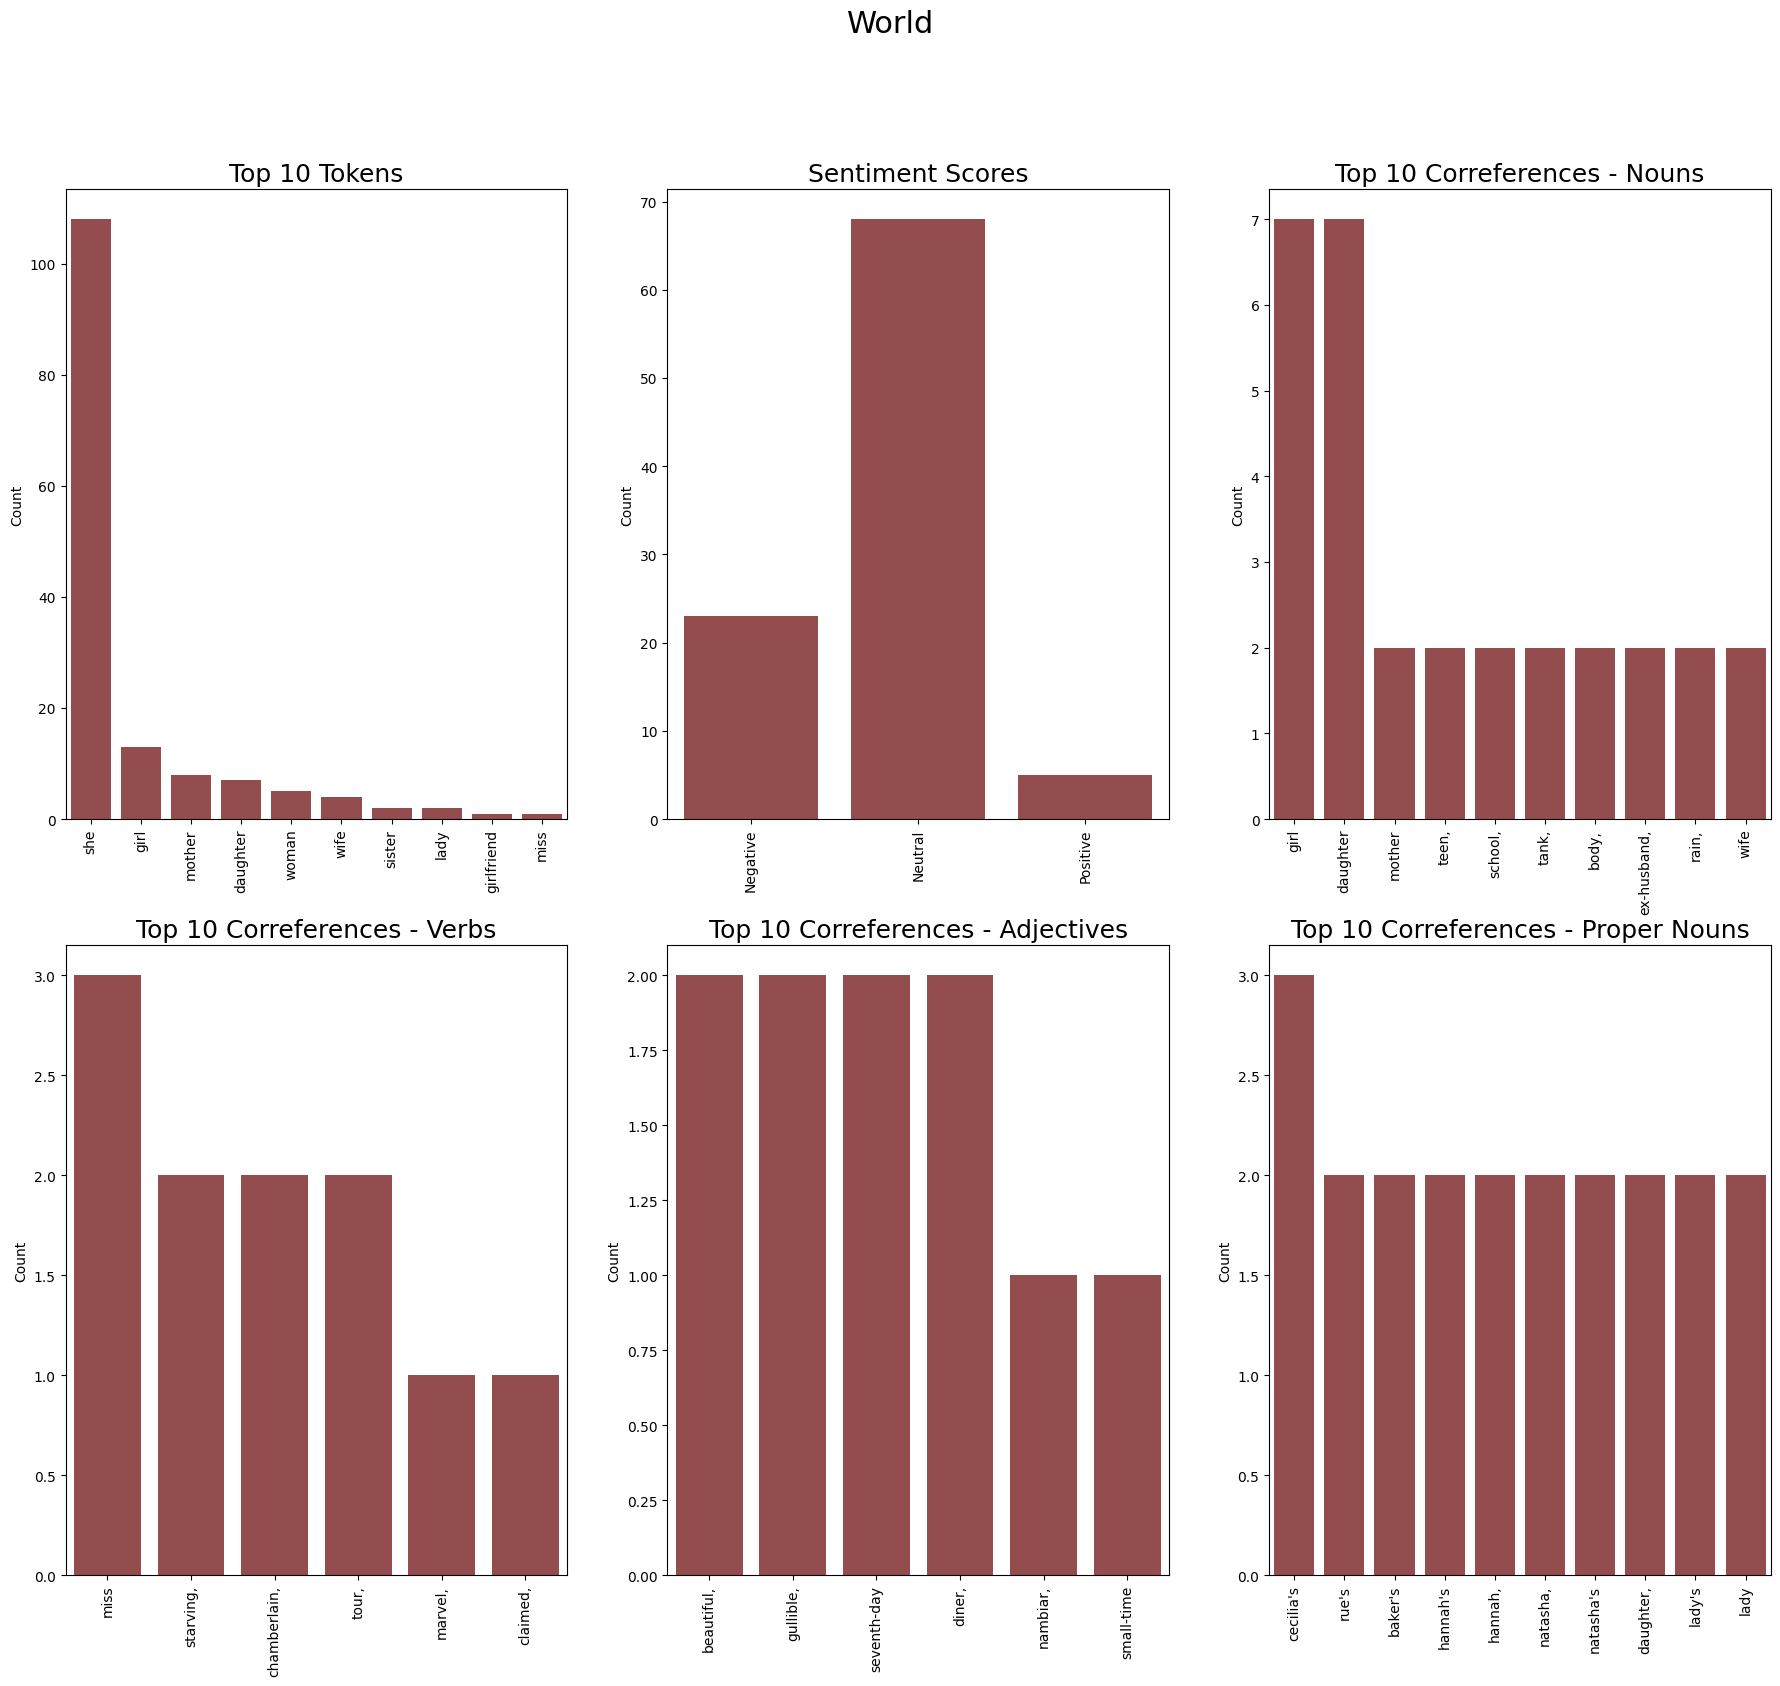

In [ ]:
plot_NLP_results(correferences_by_pos, tokens_all, sentiment_scores_all, 'World', color=world_color)

We can see several elements:
- The top 10 words (tokens) related to female that appears in the summaries.
- The sentiment scores for all sentences containing female vocabulary
- the top 10 correferences for different part of speech categories (nouns, verbs, adjectives and proper nouns)

Now that all the pipeline is ready, let's use it to compare summaries from the 4 different areas: we will first filter the the summaries by region and then sample randomly to take only 300 summaries per regions, due to the time-consuming operation of running this pipeline.

In [17]:
def filt_df(df, column_name, value):
    """ Function to filter the dataframe by a column and a value """
    df = df[df[column_name] == value]
    print(f'''Filtered via column '{column_name}' containing '{value}' Length of the returned dataframe: {len(df)}''')
    return df

In [20]:
# Separate the films per geographical regions
total_films_asia = filt_df(movies_df, 'area', 'Asia')
total_films_europe = filt_df(movies_df, 'area', 'Europe')
total_films_india = filt_df(movies_df, 'area', 'India')
total_films_northern_america = filt_df(movies_df, 'area', 'Northen America')

# Randomly select 300 films from each region
n_samples = 50
random_films_asia = total_films_asia.sample(n=n_samples, random_state=42) 
random_films_europe = total_films_europe.sample(n=n_samples, random_state=42)
random_films_india = total_films_india.sample(n=n_samples, random_state=42)
random_films_northern_america = total_films_northern_america.sample(n=n_samples, random_state=42)

# Get the wiki_id of the films per geographical regions
wiki_id_asia = random_films_asia['wiki_id'].tolist()
wiki_id_europe = random_films_europe['wiki_id'].tolist()
wiki_id_india = random_films_india['wiki_id'].tolist()
wiki_id_northern_america = random_films_northern_america['wiki_id'].tolist()

# Group in list 
wiki_ids_list = [wiki_id_asia, wiki_id_europe, wiki_id_india, wiki_id_northern_america]

# Define the regions and colors
areas = ["Asia", "Europe", "India", "Northen America"]
area_color = {
  "Asia": "#b56576",
  "Europe": "#6d597a",
  "India": "#eaac8b",
  "Northen America": "#355070"
}

Filtered via column 'area' containing 'Asia' Length of the returned dataframe: 5206
Filtered via column 'area' containing 'Europe' Length of the returned dataframe: 16331
Filtered via column 'area' containing 'India' Length of the returned dataframe: 9788
Filtered via column 'area' containing 'Northen America' Length of the returned dataframe: 36632


Let's analyze the corresponding movies and store the results in files for potential later use:

2023-12-20 10:59:06 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-12-20 10:59:08 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |
| sentiment    | sstplus             |
| ner          | ontonotes_charlm    |

2023-12-20 10:59:08 INFO: Using device: cpu
2023-12-20 10:59:08 INFO: Loading: tokenize
2023-12-20 10:59:08 INFO: Loading: pos
2023-12-20 10:59:08 INFO: Loading: lemma
2023-12-20 10:59:08 INFO: Loading: constituency
2023-12-20 10:59:09 INFO: Loading: depparse
2023-12-20 10:59:09 INFO: Loading: sentiment
2023-12-20 10:59:09 INFO: Loading: ner
2023-12-20 10:59:10 INFO: Done loading processors!
100%|██████████| 50/50 [09:13<00:00, 11.07s/it]
C:\Users\chlea\AppData\Local\Temp\ipykernel_7920\3835329325.py:112: UserWarning: Matplotlib is currently using module://matplotlib

2023-12-20 11:08:25 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |
| sentiment    | sstplus             |
| ner          | ontonotes_charlm    |

2023-12-20 11:08:25 INFO: Using device: cpu
2023-12-20 11:08:25 INFO: Loading: tokenize
2023-12-20 11:08:25 INFO: Loading: pos
2023-12-20 11:08:26 INFO: Loading: lemma
2023-12-20 11:08:26 INFO: Loading: constituency
2023-12-20 11:08:26 INFO: Loading: depparse
2023-12-20 11:08:26 INFO: Loading: sentiment
2023-12-20 11:08:27 INFO: Loading: ner
2023-12-20 11:08:27 INFO: Done loading processors!
100%|██████████| 50/50 [18:13<00:00, 21.88s/it]
C:\Users\chlea\AppData\Local\Temp\ipykernel_7920\3835329325.py:112: UserWarning: Matplotlib is currently using module://matplotlib

2023-12-20 11:26:43 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |
| sentiment    | sstplus             |
| ner          | ontonotes_charlm    |

2023-12-20 11:26:43 INFO: Using device: cpu
2023-12-20 11:26:43 INFO: Loading: tokenize
2023-12-20 11:26:43 INFO: Loading: pos
2023-12-20 11:26:44 INFO: Loading: lemma
2023-12-20 11:26:44 INFO: Loading: constituency
2023-12-20 11:26:44 INFO: Loading: depparse
2023-12-20 11:26:44 INFO: Loading: sentiment
2023-12-20 11:26:44 INFO: Loading: ner
2023-12-20 11:26:45 INFO: Done loading processors!
100%|██████████| 50/50 [03:29<00:00,  4.18s/it]
C:\Users\chlea\AppData\Local\Temp\ipykernel_7920\3835329325.py:112: UserWarning: Matplotlib is currently using module://matplotlib

2023-12-20 11:30:17 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |
| sentiment    | sstplus             |
| ner          | ontonotes_charlm    |

2023-12-20 11:30:17 INFO: Using device: cpu
2023-12-20 11:30:17 INFO: Loading: tokenize
2023-12-20 11:30:17 INFO: Loading: pos
2023-12-20 11:30:17 INFO: Loading: lemma
2023-12-20 11:30:17 INFO: Loading: constituency
2023-12-20 11:30:18 INFO: Loading: depparse
2023-12-20 11:30:18 INFO: Loading: sentiment
2023-12-20 11:30:18 INFO: Loading: ner
2023-12-20 11:30:19 INFO: Done loading processors!
100%|██████████| 50/50 [12:21<00:00, 14.82s/it]
C:\Users\chlea\AppData\Local\Temp\ipykernel_7920\3835329325.py:112: UserWarning: Matplotlib is currently using module://matplotlib

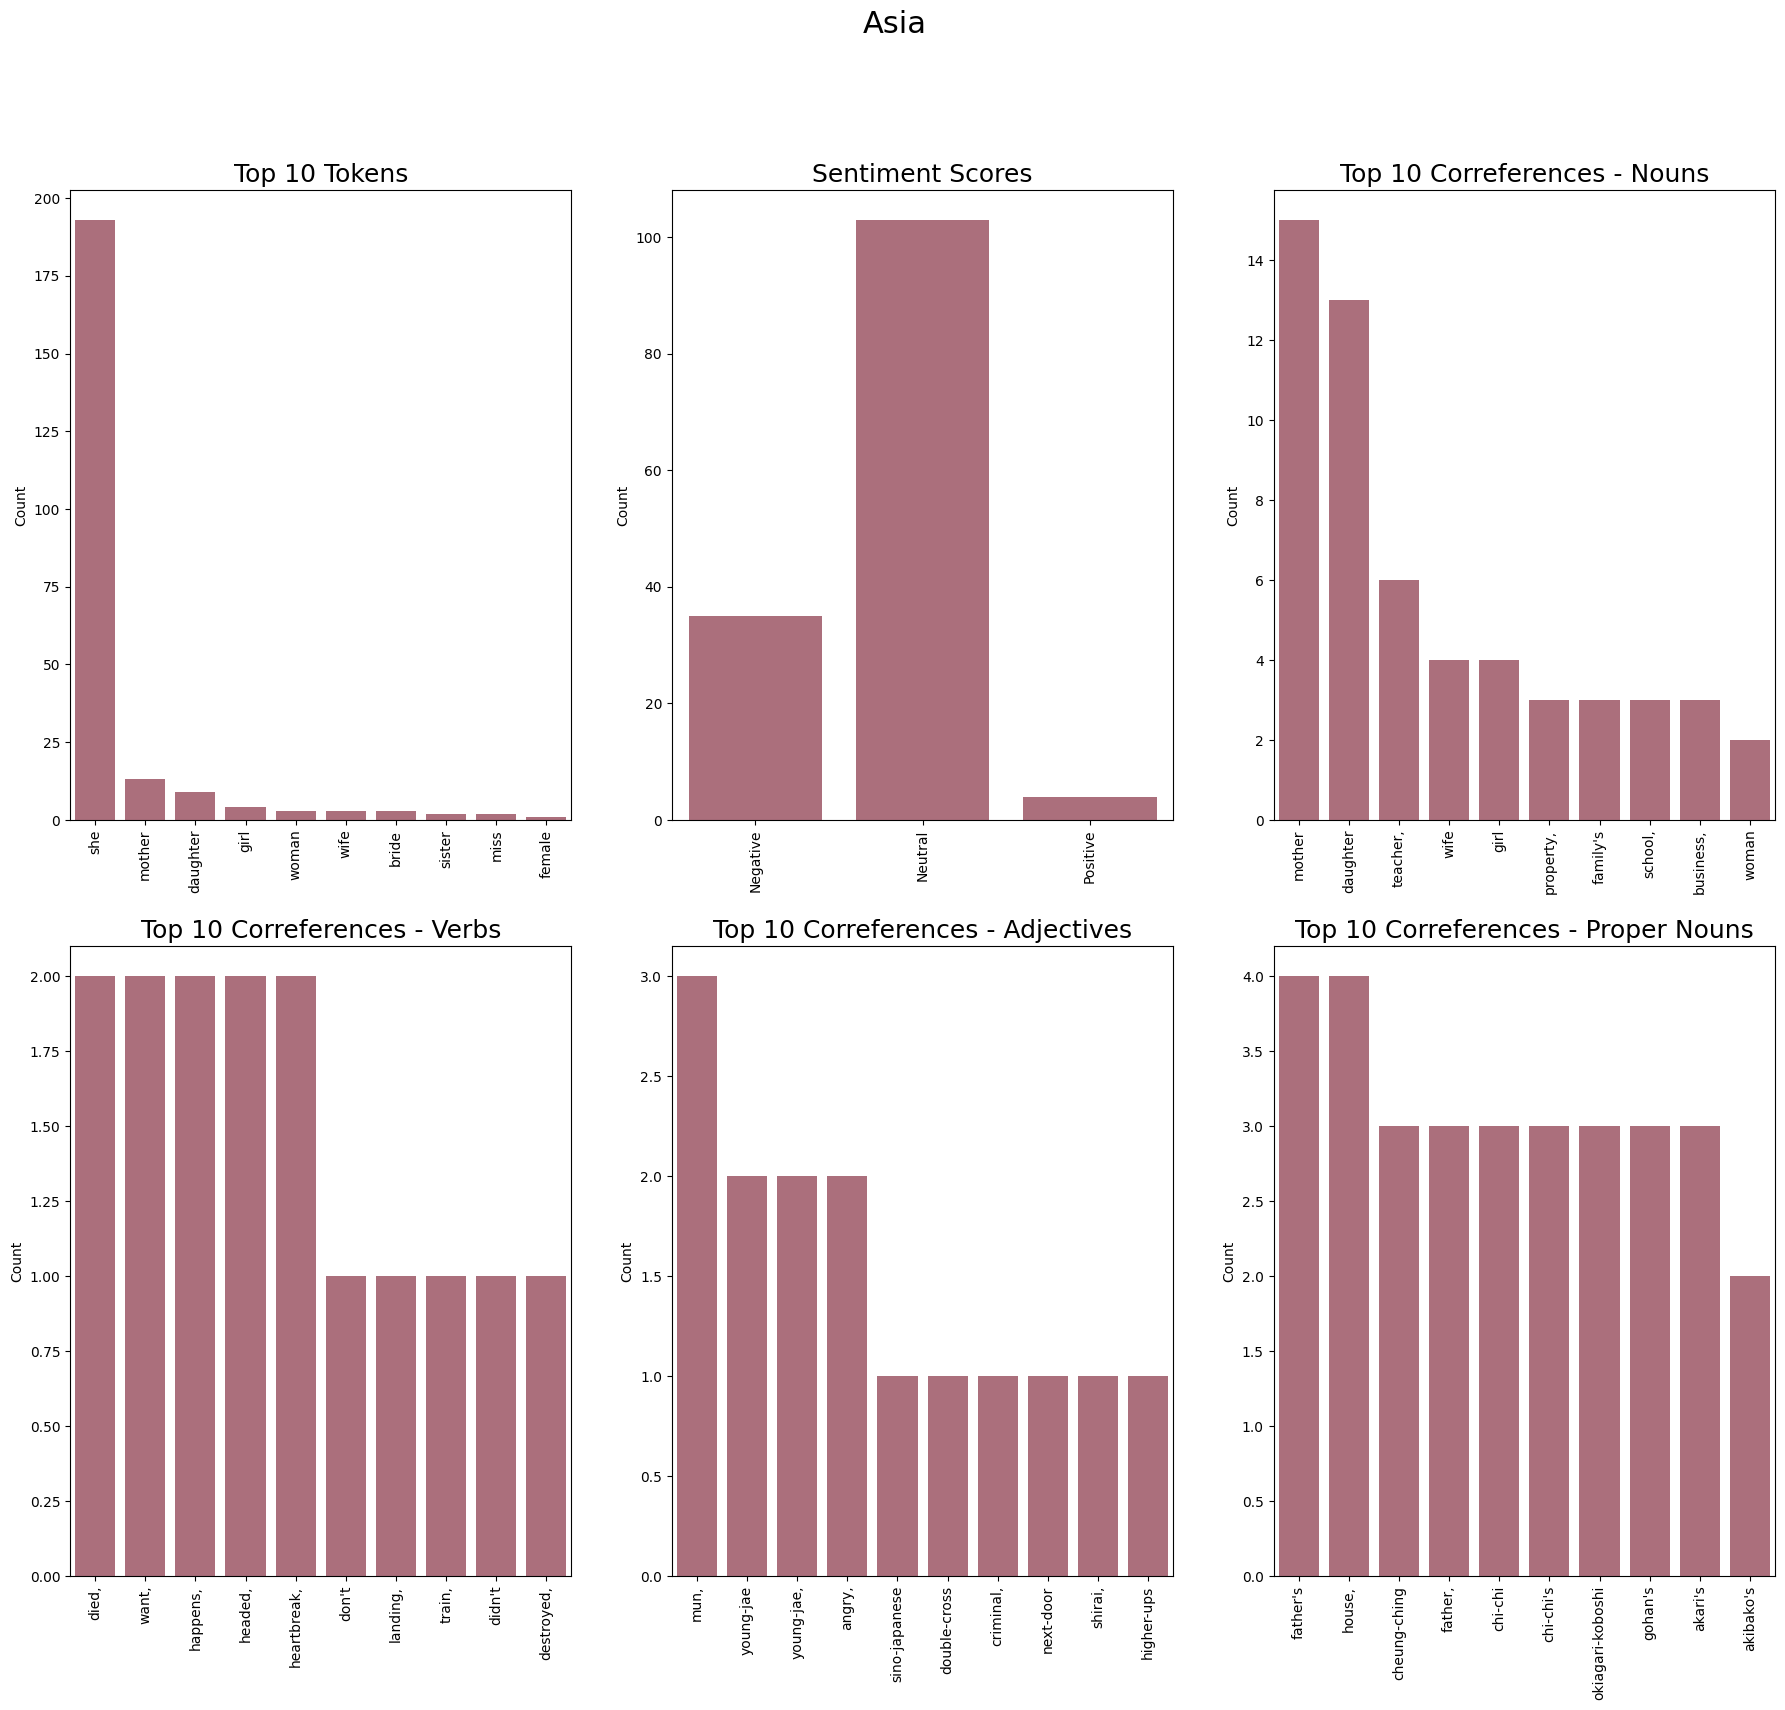

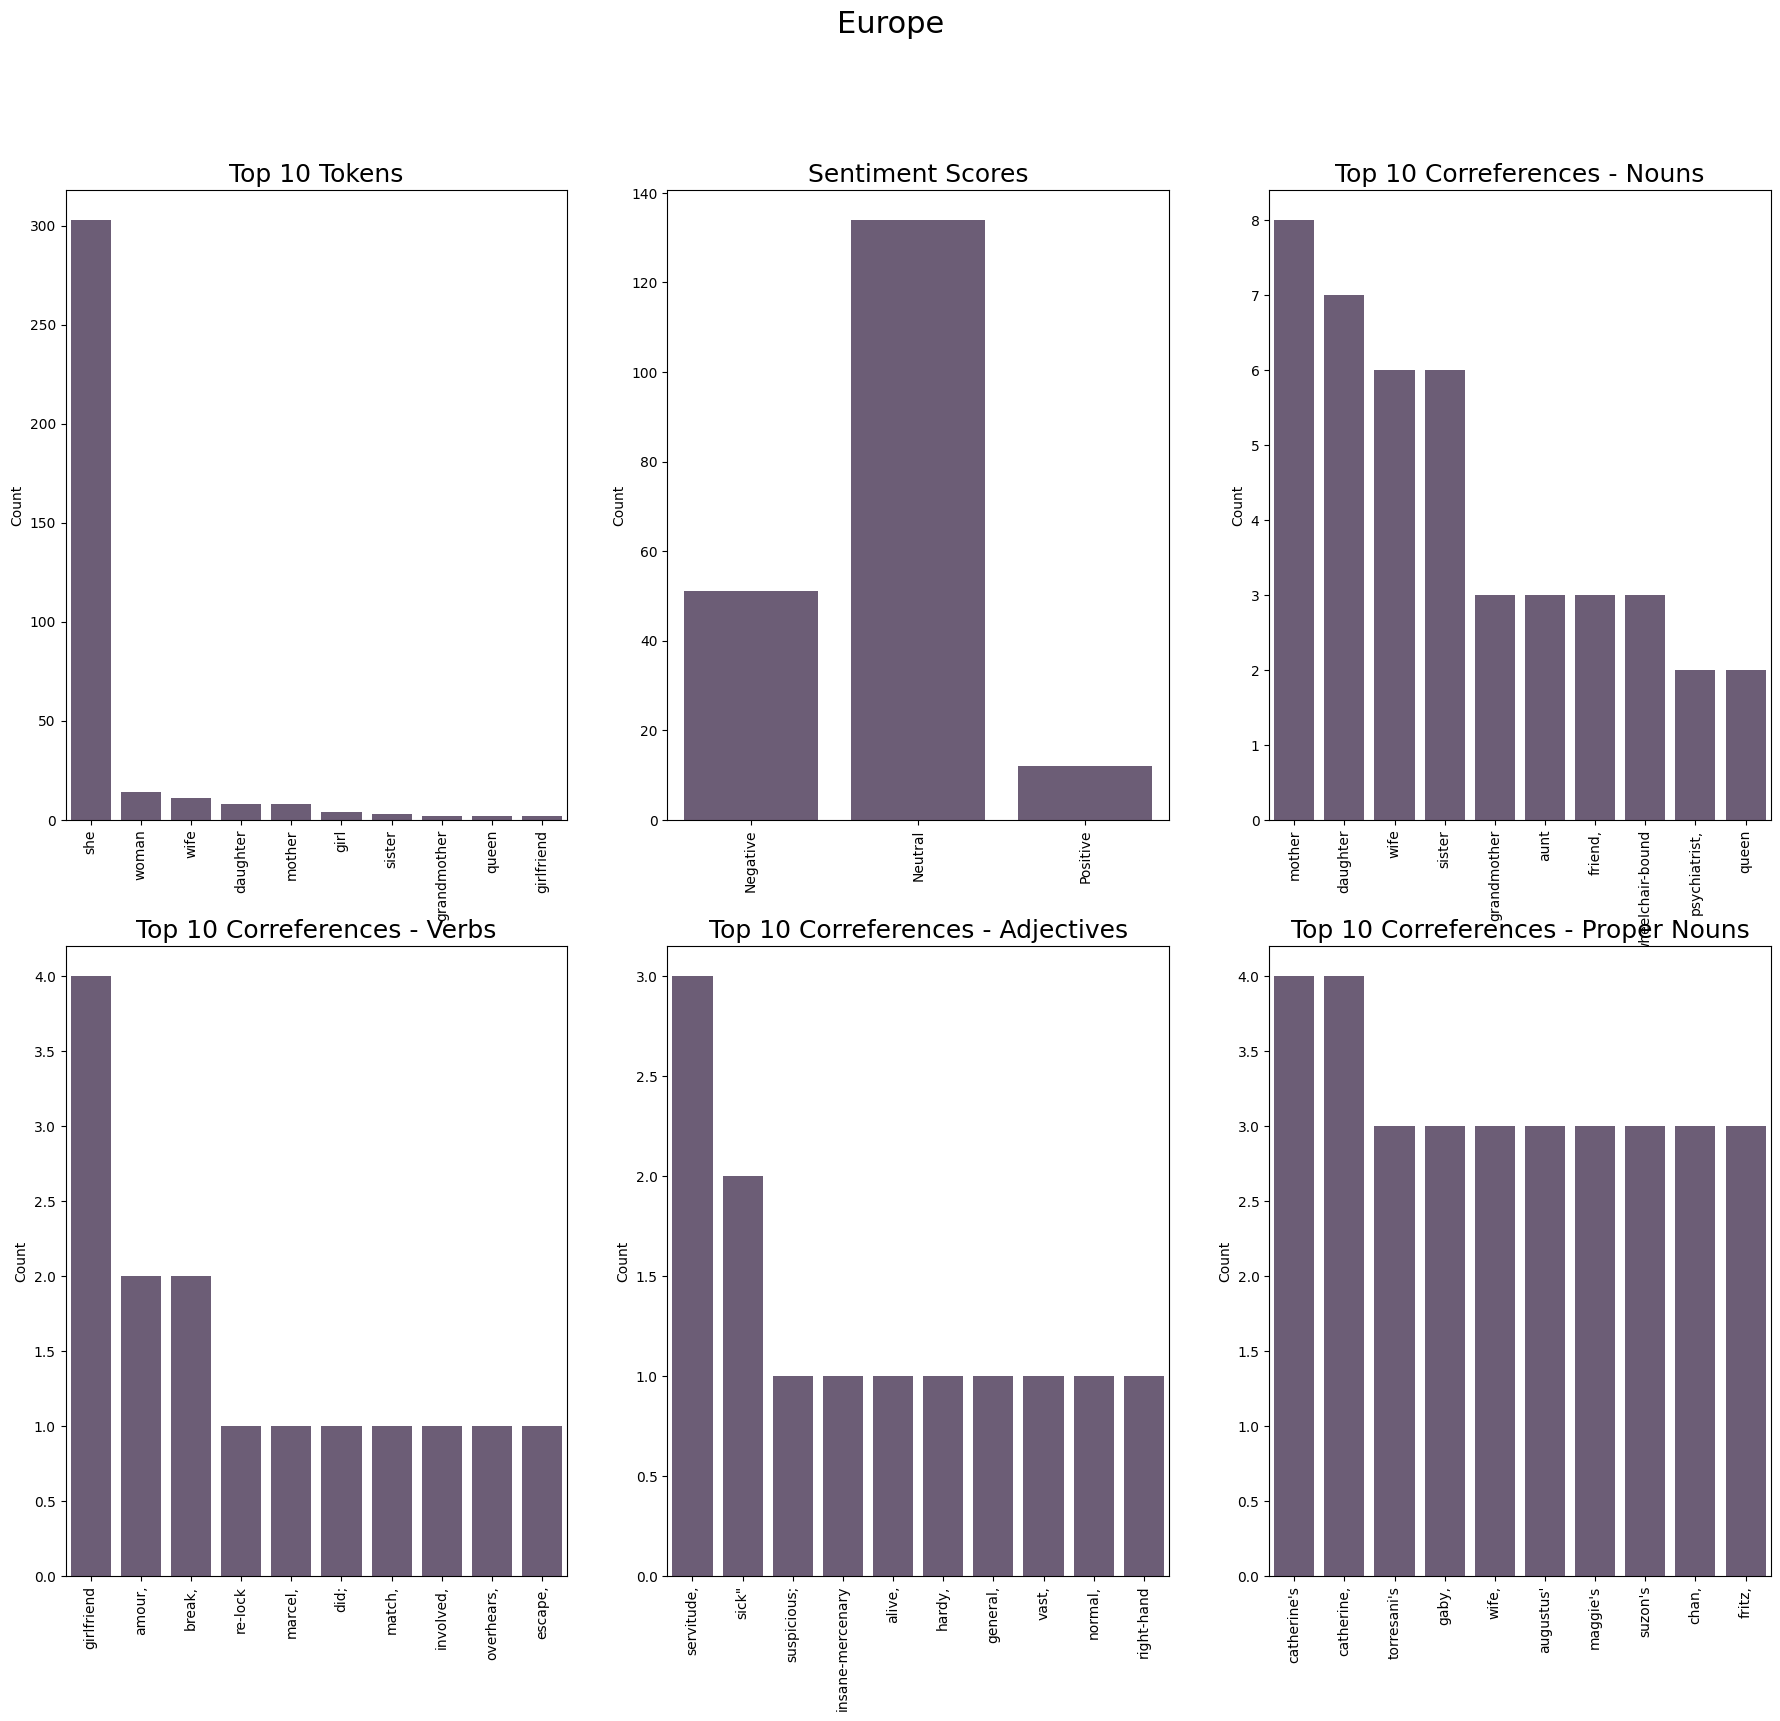

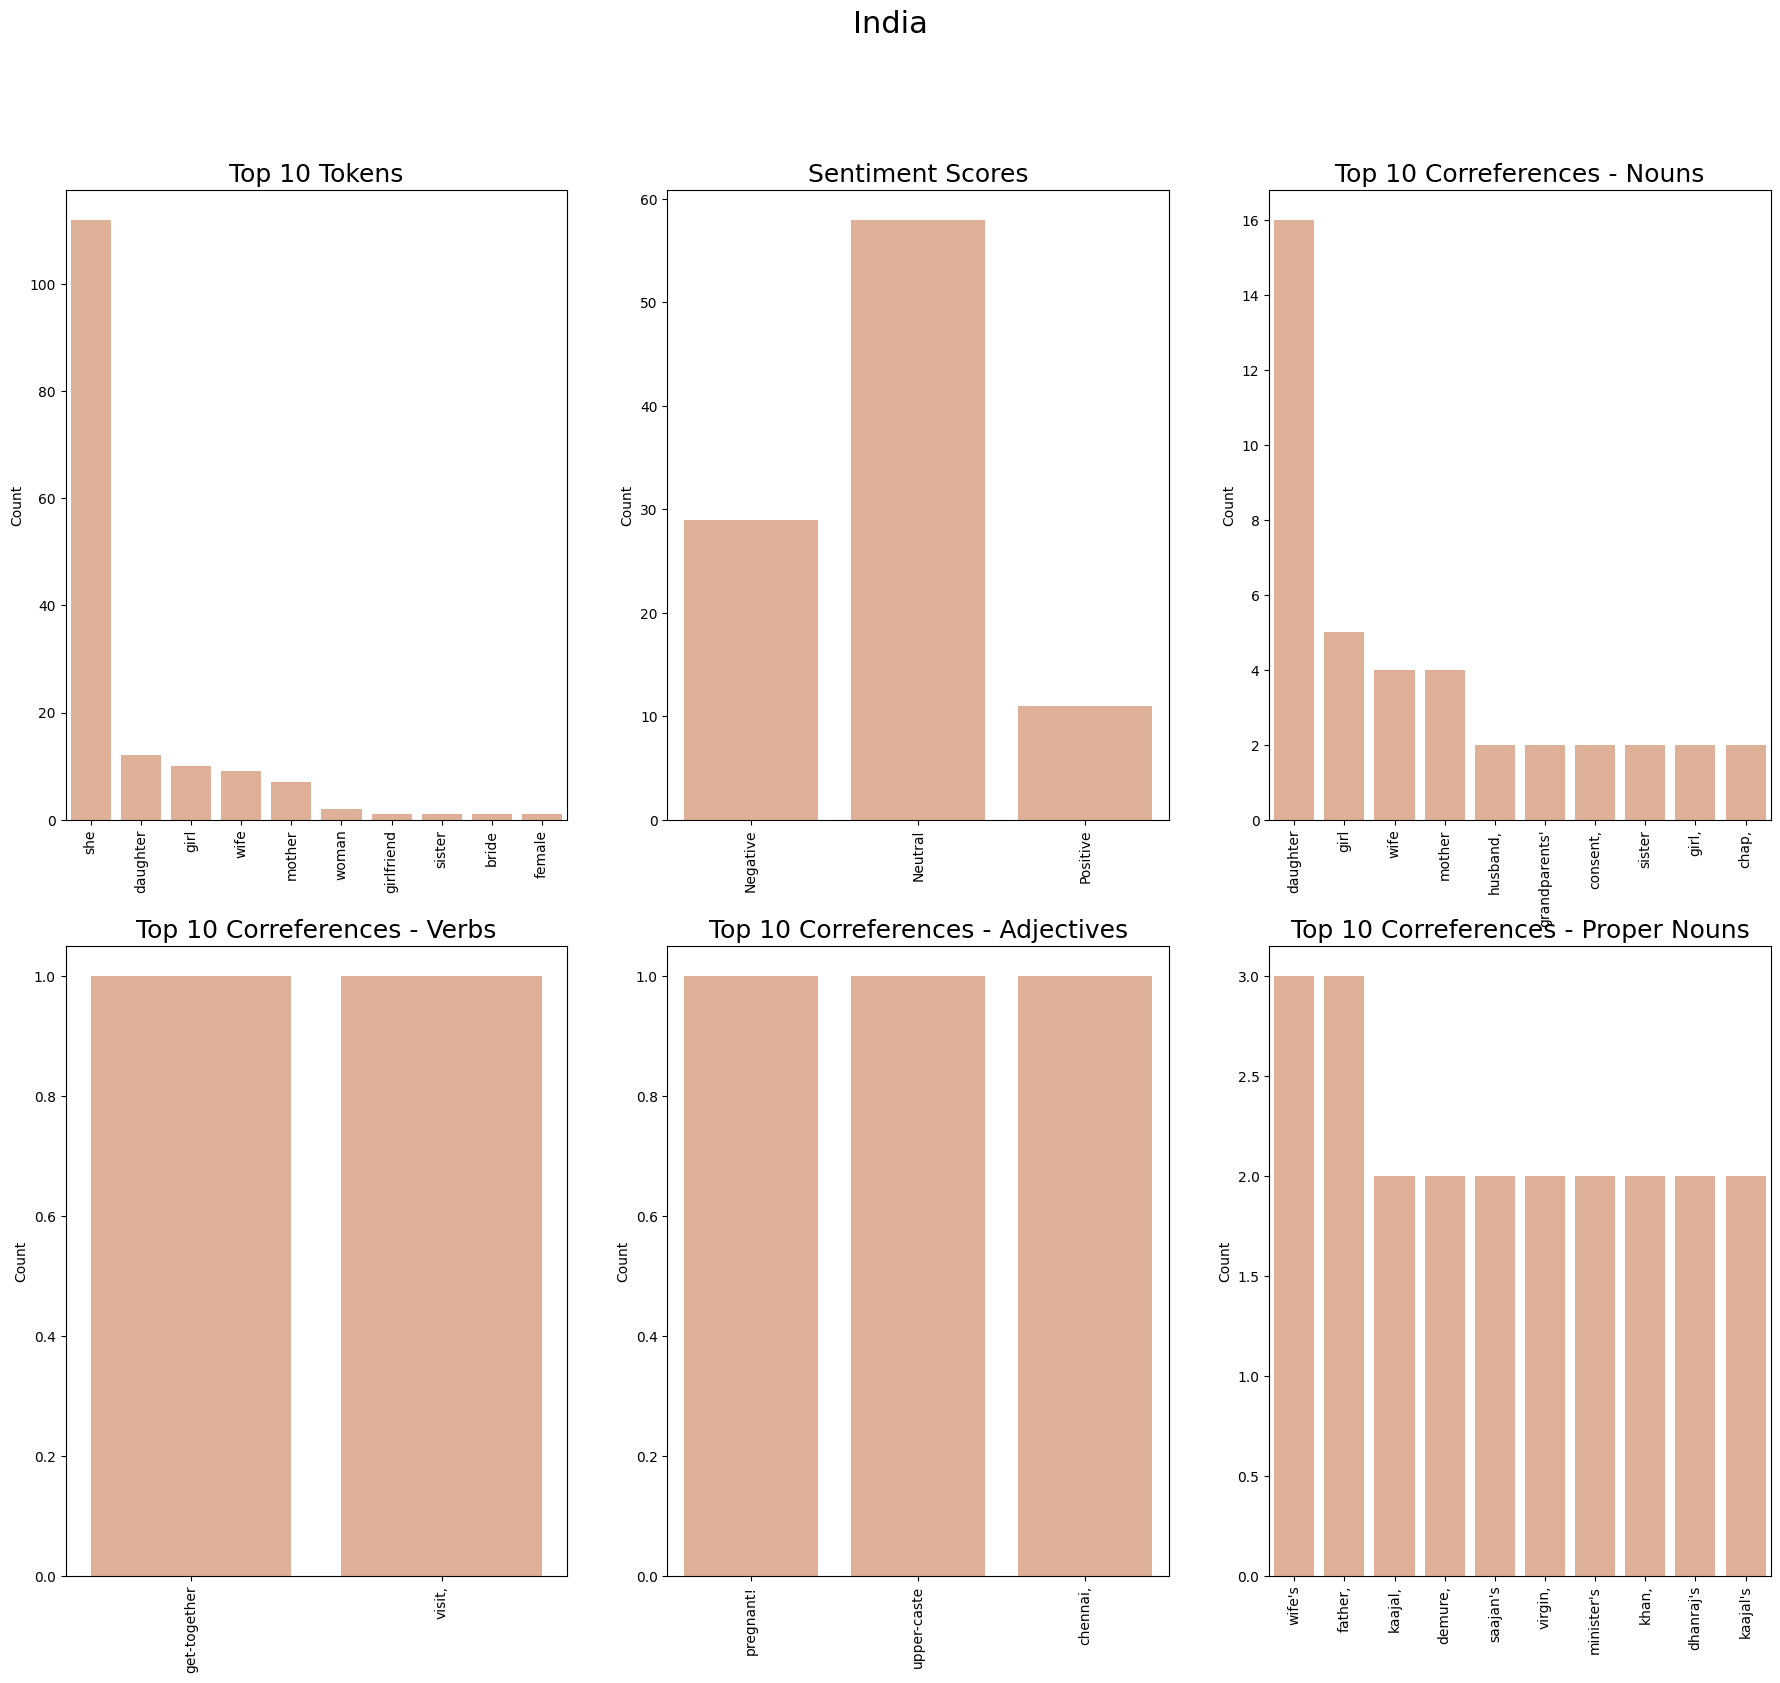

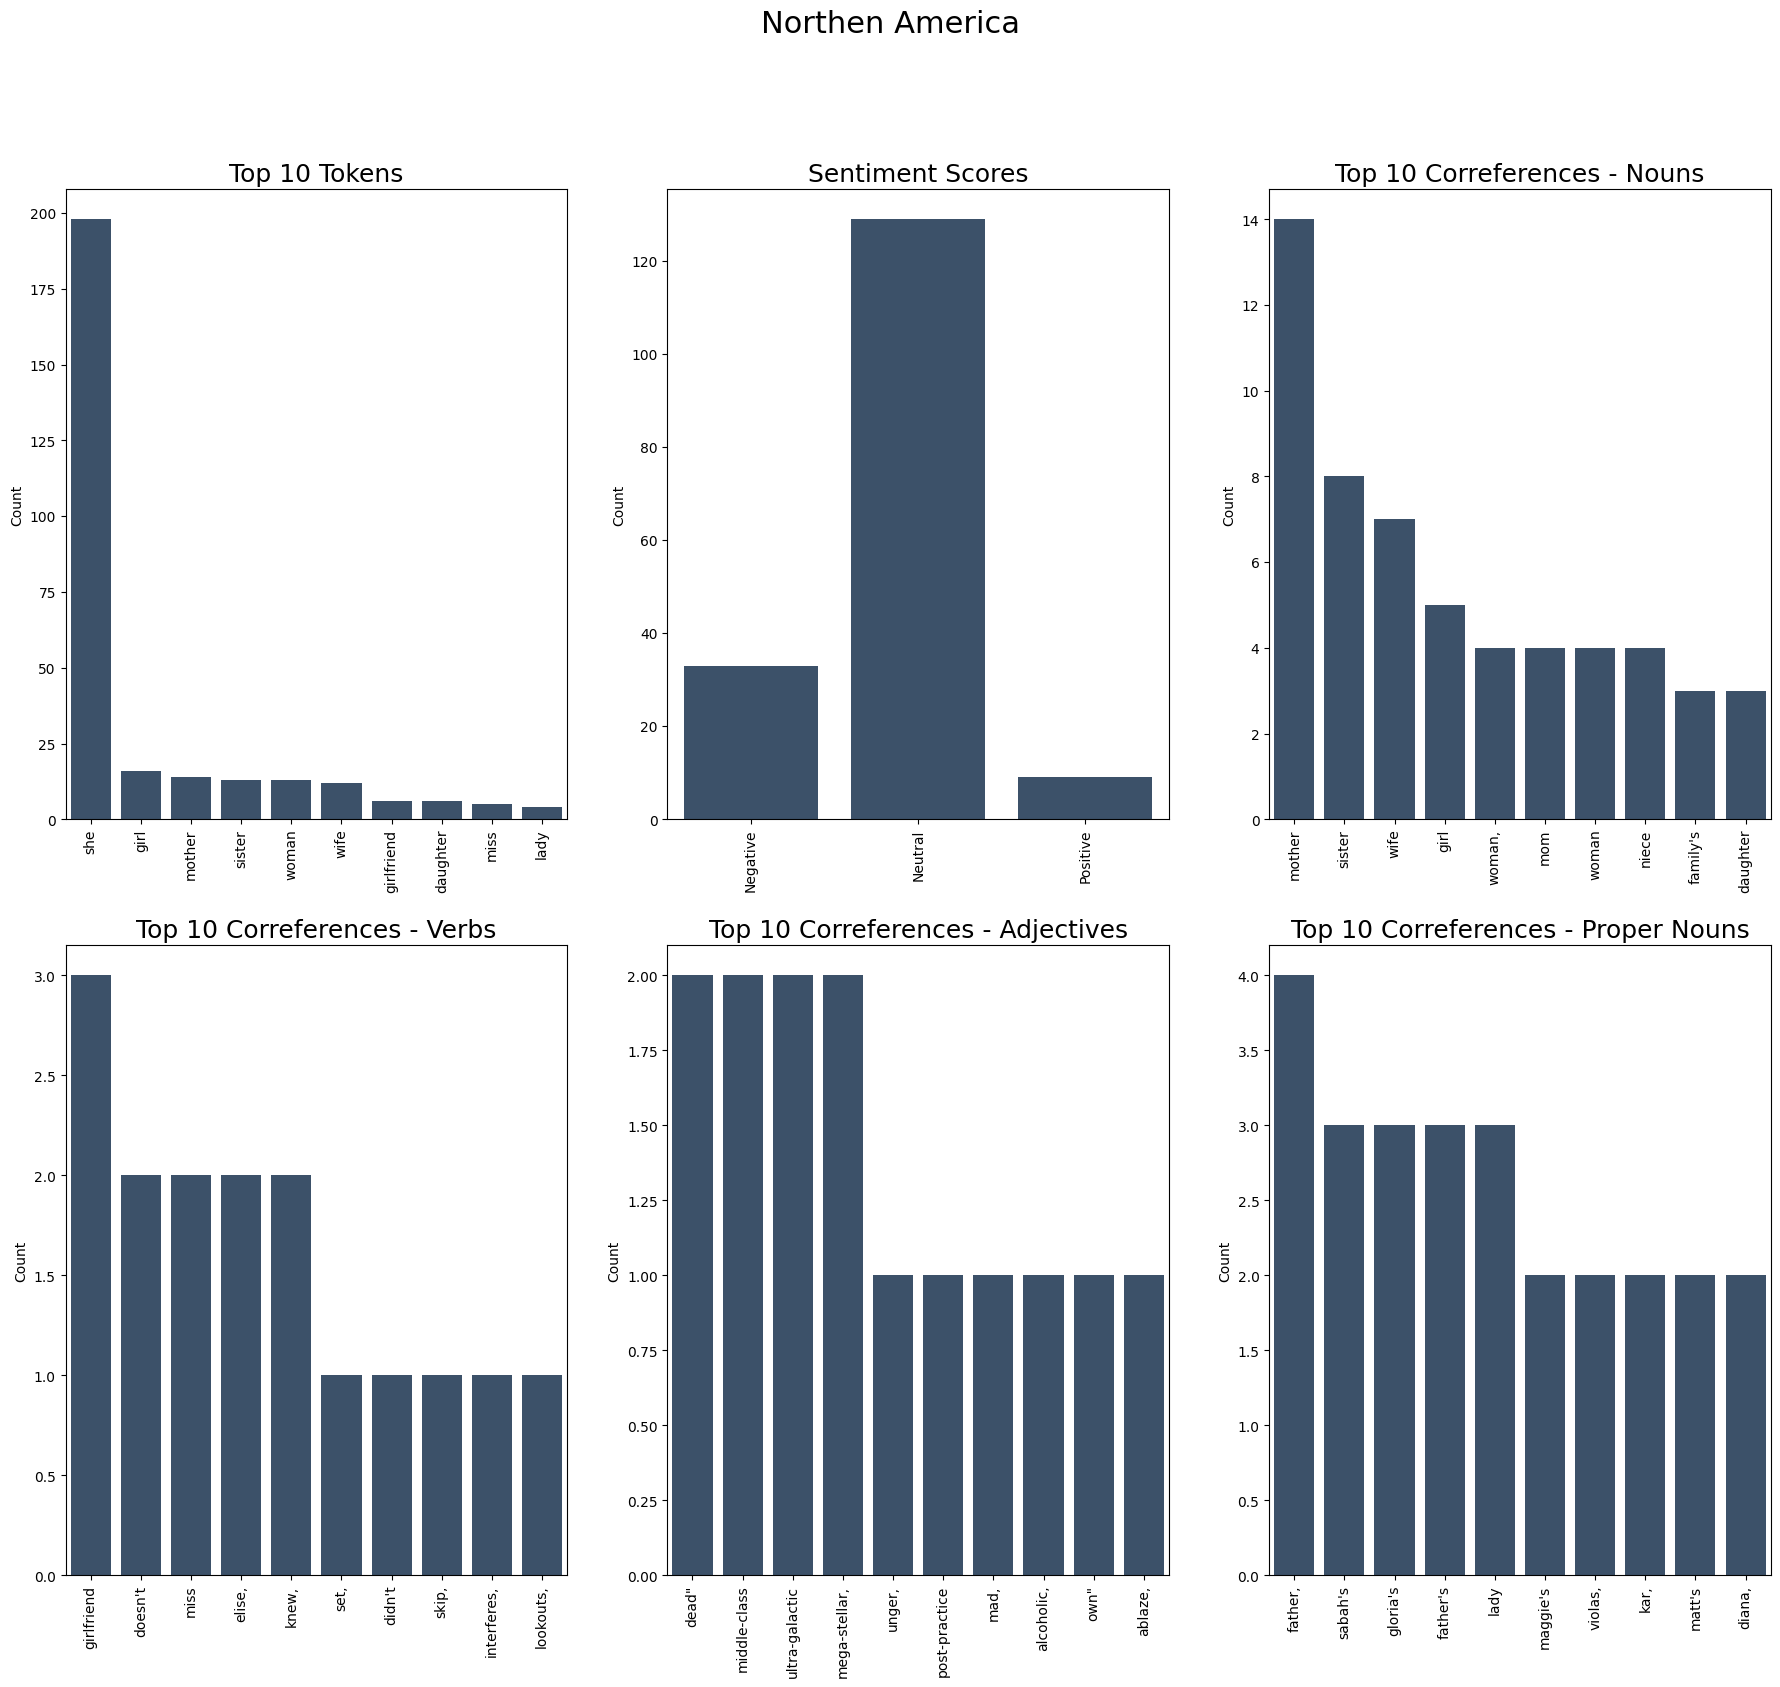

In [22]:
for wiki_ids, region, color in zip(wiki_ids_list, areas, area_color):
    # FIXME: load only once the nlp pipeline and put it in the function arguments
    # Extract NLP data
    vocabulary_dict_all, tokens_all, sentiment_scores_all, correferences_all, correferences_by_pos = analyze_NLP_data(wiki_ids,data_folder,vocabulary,print_results=False)

    # Save the results
    with open(f"clean_data/NLP_results/{region}_vocabulary_dict_all.json", "w") as json_file:
        json.dump(vocabulary_dict_all, json_file) 
    with open(f"clean_data/NLP_results/{region}_tokens_all.json", "w") as json_file:
        json.dump(tokens_all, json_file)
    with open(f"clean_data/NLP_results/{region}_sentiment_scores_all.json", "w") as json_file:
        json.dump(sentiment_scores_all, json_file)
    with open(f"clean_data/NLP_results/{region}_correferences_all.json", "w") as json_file:
        json.dump(correferences_all, json_file)
    with open(f"clean_data/NLP_results/{region}_correferences_by_pos.json", "w") as json_file:
        json.dump(correferences_by_pos, json_file)

    # Plot results
    color = area_color[region]
    plot_NLP_results(correferences_by_pos, tokens_all, sentiment_scores_all, region, color)

To get the saved NLP results, we can load the json files:

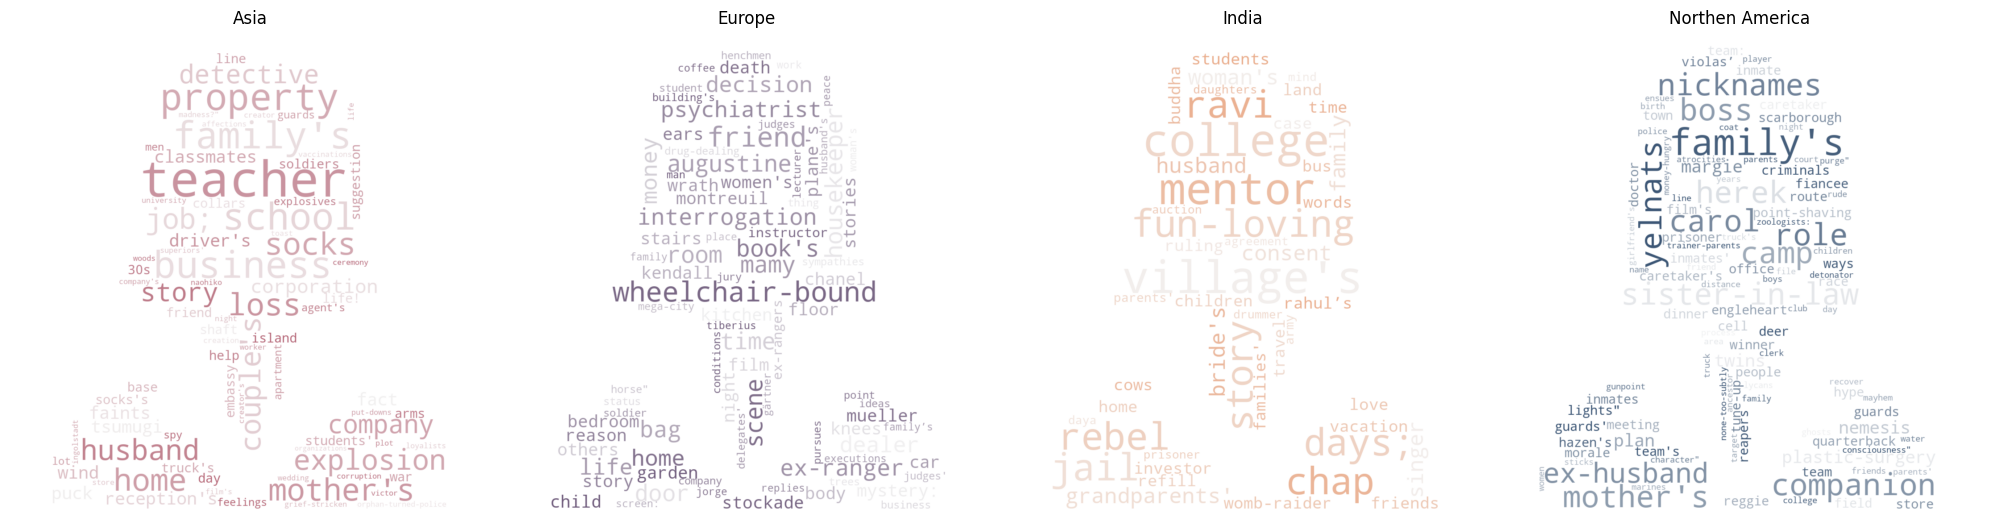

In [50]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
for i,area in enumerate(areas):
    # Load the results
    with open(f"clean_data/NLP_results/{area}_correferences_by_pos.json", "r") as json_file:
        correferences_by_pos = json.load(json_file)

    # mask
    #mask = np.array(Image.open(f"{area}.png"))
    mask = np.array(Image.open("femme.png"))

    # Flatten nouns
    nouns = [str(word).replace(",", "") for word in correferences_by_pos['NOUN']]
    nouns = [word for word in nouns if word not in vocabulary]

    # Count occurences
    counts = Counter(nouns)

    # Create a word cloud
    wordcloud = WordCloud(height=200,background_color="white", colormap=area_palette[area], mask=mask).generate_from_frequencies(counts)
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(area)
    ax.axis("off")
    ax.set_aspect('equal')

    # Save the wordcloud
    #wordcloud.to_file(f"clean_data/NLP_results/{area}_wordcloud.png")

plt.tight_layout()
plt.show()

In [ ]:
# FIXME:
# DONE - pas d'influence si majuscule ou minuscule --> string.lower() 
# DONE - vocabulary: get a much larger list of words --> use wordnet --> wn.synsets('female')
# DONE - enlever les noms propres --> coreference --> search in token_dict --> get NER --> remove if PERSON --> only adjectives + nouns + verbs
# - wordclouds coreferences

In [ ]:
# TODO
# DONE - reduce the nb of films to analyze?
# - analysis female vs male 
# - analysis on other topics?